In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
from tensorflow.keras.layers import Conv2D, Input, Concatenate, Activation, MaxPool2D, UpSampling2D, GroupNormalization, \
                                    Add, Multiply
from tensorflow.keras.models import Model

In [3]:
print(tf.config.list_physical_devices())

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


In [4]:
def conv(x, filters=8, activation="swish"):
    for i in range(2):
        x = Conv2D(filters, (3,3), padding='same')(x)
        x = GroupNormalization(groups=-1)(x) # InstanceNorm
        x = Activation(activation)(x)
        
    return x

In [5]:
def unet(filters=8, layers=4, input_shape=(256,256,1), activation='swish'):
    to_concat = []
    
    model_in = Input(input_shape)
    x = model_in
    
    # Encoder
    for i in range(layers):
        x = conv(x, filters*2**i, activation)
        to_concat.append(x)
        x = MaxPool2D()(x)
    
    # Latent
    x = Conv2D(filters*2**layers, (3,3), padding='same')(x)
    x = GroupNormalization(groups=-1)(x)  # InstanceNorm
    x = Activation(activation)(x)
    
    # Decoder
    for i in range(layers):
        x = UpSampling2D()(x)
        x = Concatenate()([x, to_concat.pop()])
        x = conv(x, filters*2**(layers-i-1), activation)
    
    x = Conv2D(1, (1,1), padding='same')(x)
    model_out = Activation("sigmoid")(x)
    
    return Model(model_in, model_out)

In [6]:
m = unet()

In [7]:
def nestedUnet(nests=4, filters=1, forward_input=True, operation="multiply", input_shape=(256, 256, 1)):
    x = Input(input_shape)
    
    m0 = unet(filters, input_shape=input_shape)(x)
    
    if nests > 1:
        tmp = m0
        
        for i in range(nests-1):
            if forward_input:
                if operation == 'add':
                    tmp = Add()([x, tmp])
                    
                elif operation == 'multiply':
                    tmp = Multiply()([x, tmp])
                    
                else:
                    tmp = Concatenate(axis=3)([x, tmp])
                
            tmp = unet(filters, input_shape=tmp.shape[1:])(tmp)

        return Model(x, tmp)        
        
    else:
        return Model(x, m0)

In [8]:
y = nestedUnet(4, 1)
y.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 256, 256, 1)]        0         []                            
                                                                                                  
 model_1 (Functional)        (None, 256, 256, 1)          5594      ['input_2[0][0]']             
                                                                                                  
 multiply (Multiply)         (None, 256, 256, 1)          0         ['input_2[0][0]',             
                                                                     'model_1[0][0]']             
                                                                                                  
 model_2 (Functional)        (None, 256, 256, 1)          5594      ['multiply[0][0]']      

In [9]:
X = np.zeros((128, 256, 256, 1), dtype=np.float32)

X[:, 100:140, 80:120] = 1

(256, 256)

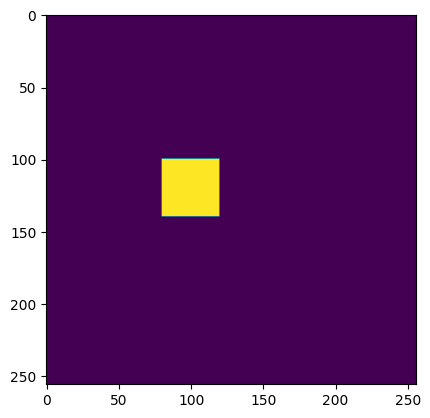

In [31]:
plt.imshow(X.sum((0,3)))
X.sum((0,3)).shape

In [11]:
y.compile("adam", "mse")

In [12]:
h = y.fit(X, X, batch_size=4, epochs=10)

Epoch 1/10
32/32 [==============================] - 143s 2s/step - loss: 0.2281
Epoch 2/10
32/32 [==============================] - 35s 1s/step - loss: 0.2151
Epoch 3/10
32/32 [==============================] - 41s 1s/step - loss: 0.2041
Epoch 4/10
32/32 [==============================] - 51s 2s/step - loss: 0.1935
Epoch 5/10
32/32 [==============================] - 54s 2s/step - loss: 0.1833
Epoch 6/10
32/32 [==============================] - 50s 2s/step - loss: 0.1736
Epoch 7/10
32/32 [==============================] - 59s 2s/step - loss: 0.1644
Epoch 8/10
32/32 [==============================] - 58s 2s/step - loss: 0.1556
Epoch 9/10
32/32 [==============================] - 56s 2s/step - loss: 0.1473
Epoch 10/10
32/32 [==============================] - 55s 2s/step - loss: 0.1395


4/4 [==============================] - 31s 2s/step


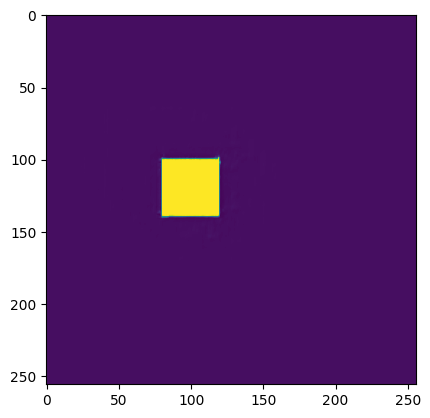

In [13]:
plt.imshow(y.predict(X).sum((0,3)))